In [1]:
from huggingface_hub import login
login()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import json
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
ds = load_dataset("allenai/WildChat")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00006.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/529428 [00:00<?, ? examples/s]

In [3]:
df = pd.DataFrame(ds['train'])

# Filter to include only English-language conversations
df = df[df['language'] == 'English']

In [50]:
## Dataset Stats

print("Dataset summary")
print("-" * 40)
print(f"Total number of English conversations: {len(df):,}")
print(f"DataFrame shape: {df.shape}")
print(f"Estimated memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nBasic statistics")
print("-" * 40)
print(f"Timestamp range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Average number of turns per conversation: {df['turn'].mean():.1f}")
print(f"Median number of turns: {df['turn'].median():.1f}")

print("\nModel usage breakdown")
print("-" * 40)
print(df['model'].value_counts())

print("\nDistribution of conversation lengths by number of turns")
print("-" * 40)
turn_counts = df['turn'].value_counts().sort_index().head(10)
for turns, count in turn_counts.items():
    print(f"{turns} turns: {count:,} conversations")

Dataset summary
----------------------------------------
Total number of English conversations: 284,168
DataFrame shape: (284168, 10)
Estimated memory usage: 159.2 MB

Basic statistics
----------------------------------------
Timestamp range: 2023-04-10 00:01:08+00:00 to 2023-11-09 16:22:16+00:00
Average number of turns per conversation: 2.2
Median number of turns: 1.0

Model usage breakdown
----------------------------------------
model
gpt-3.5-turbo         245165
gpt-4                  38718
gpt-4-1106-preview       285
Name: count, dtype: int64

Distribution of conversation lengths by number of turns
----------------------------------------
1 turns: 179,892 conversations
2 turns: 41,352 conversations
3 turns: 21,406 conversations
4 turns: 12,520 conversations
5 turns: 7,851 conversations
6 turns: 5,351 conversations
7 turns: 3,778 conversations
8 turns: 2,892 conversations
9 turns: 2,118 conversations
10 turns: 1,528 conversations


In [ ]:
def get_first_user_message(conversation):
    """
    Extracts the first user message from a conversation list.

    Parameters:
        conversation (list): A list of utterance dicts with 'role' and 'content'.

    Returns:
        str or None: Content of the first user utterance, or None if not found.
    """
    return next((msg['content'] for msg in conversation if msg['role'] == 'user'), None)


def summarize_conversation(row):
    """
    Extracts summary stats and metadata from a single conversation row.

    Parameters:
        row (pd.Series): A row from the DataFrame with a 'conversation' field.

    Returns:
        dict: Summary info including turn counts, timestamp, and first user message.
    """
    conversation = row['conversation']
    first_user = get_first_user_message(conversation)

    return {
        'conversation_id': row['conversation_id'],
        'first_user_message': first_user,
        'total_turns': len(conversation),
        'user_turns': sum(1 for msg in conversation if msg['role'] == 'user'),
        'assistant_turns': sum(1 for msg in conversation if msg['role'] == 'assistant'),
        'timestamp': row['timestamp'],
        'model': row['model'],
        'toxic': row['toxic'],
        'redacted': row['redacted']
    }

results = []
for idx, row in df.iterrows():
    info = summarize_conversation(row)
    if info['first_user_message'] is not None:
        results.append(info)

    if (idx + 1) % 50_000 == 0:
        print(f"  Processed {idx + 1:,} rows")

df_messages = pd.DataFrame(results)

In [60]:
## Intent Classifier
import re
class IntentClassifier:
    """
    Rule-based intent classifier using regex pattern matching.
    """

    def __init__(self):
        self.intent_patterns = {
            'Information_Seeking': [
                r'\b(what is|what are|explain|tell me about|define|meaning of)\b',
                r'\b(how does .* work|what does .* mean|why is|why does)\b',
                r'^\s*(what|who|when|where|why|how)\b',
                r'\b(information about|details about|learn about)\b',
                r'\b(is it good|is it bad|normal)\b'
            ],
            'Problem_Solving': [
                r'\b(how to|how can I|help me|fix|solve|resolve|troubleshoot)\b',
                r'\b(not working|error|issue|problem|trouble|broken)\b',
                r'\b(step by step|guide|tutorial|instructions)\b',
                r'\b(debug|repair|correct)\b',
                r'\b(alternatives|alternative to)\b'
            ],
            'Creative_Assistance': [
                r'\b(write|create|generate|make|compose|design)\b',
                r'\b(story|poem|article|essay|script|song|content)\b',
                r'\b(brainstorm|ideas for|creative|imagine)\b',
                r'\b(draft|outline|template)\b',
                r'\b(episode|synopsis|character.*react)\b'
            ],
            'Decision_Support': [
                r'\b(should I|which|compare|better|recommend|suggest|advice)\b',
                r'\b(pros and cons|advantages|disadvantages|best|worst)\b',
                r'\b(choose|decision|option|alternative)\b',
                r'\b(evaluate|assess|judge)\b'
            ],
            'Learning_Skill_Development': [
                r'\b(teach me|learn|study|practice|exercise|training)\b',
                r'\b(lesson|course|tutorial|guide|education)\b',
                r'\b(skill|technique|method|approach)\b',
                r'\b(beginner|basic|advanced|intermediate)\b'
            ],
            'Coding_Programming': [
                r'\b(code|function|script|programming|python|javascript|html|css|php|java|sql)\b',
                r'\b(algorithm|debug|compile|syntax|variable|array|loop|class)\b',
                r'\b(github|repository|api|database|framework|library)\b',
                r'\b(visual studio|vscode|extension|discord.*extension)\b',
                r'^\s*[#<>{}()\[\];]', 
                r'\b(UPDATE|SELECT|FROM|JOIN|WHERE)\b',
                r'\b(def |function |var |let |const )\b'
            ],
            'Text_Editing_Formatting': [
                r'\b(format|edit|rewrite|improve|polish|revise|summarize|rephrase)\b',
                r'\b(proofread|correct|grammar|spelling|style)\b',
                r'\b(shorten|expand|condense|elaborate)\b',
                r'\b(in less than.*words|word limit|character limit)\b'
            ],
            'Translation_Language': [
                r'\b(translate|translation|語|中文|español|français|deutsch|русский)\b',
                r'\b(english to|spanish to|french to|chinese to|russian to)\b',
                r'\b(language|lingua|idioma|sprache)\b'
            ],
            'Math_Calculations': [
                r'\b(calculate|solve|equation|math|formula|computation)\b',
                r'\d+\s*[+\-*/=]\s*\d+',
                r'\b(algebra|geometry|calculus|statistics|probability)\b',
                r'\b(sum|average|mean|median|standard deviation)\b'
            ],
            'Roleplay_Character': [
                r'\([^)]*\):\s*["\']',
                r'\b(character|roleplay|scenario|in the.*of)\b',
                r'\b(naruto|anime|game|fantasy|desert|biome)\b',
                r'\b.*switch bodies.*\b',
                r'\b.*react to.*\b'
            ],
            'General_Conversation': [
                r'^\s*(hi|hello|hey|good morning|good evening|greetings)\s*!?$',
                r'^\s*(thanks|thank you|thx)\s*!?$',
                r'^\s*(bye|goodbye|see you|farewell)\s*!?$',
                r'\b(tips of the day|did you know)\b'
            ]
        }

    def classify_intent(self, text):
        """
        Classify a user message based on regex pattern matches.
        Returns:
            str: Intent category, or 'Unknown' or 'Mixed' if ambiguous.
        """
        if not text or pd.isna(text):
            return 'Unknown'

        text_lower = text.lower().strip()

        if len(text_lower) <= 10:
            for pattern in self.intent_patterns['General_Conversation']:
                if re.search(pattern, text_lower):
                    return 'General_Conversation'
            return 'General_Conversation'

        if len(text_lower) >= 500:
            for pattern in self.intent_patterns['Coding_Programming']:
                if re.search(pattern, text_lower):
                    return 'Coding_Programming'

        # Score matches for each category
        intent_scores = {}
        for intent, patterns in self.intent_patterns.items():
            score = 0
            for pattern in patterns:
                try:
                    score += len(re.findall(pattern, text_lower))
                except re.error:
                    continue
            intent_scores[intent] = score

        max_score = max(intent_scores.values())
        if max_score == 0:
            return 'Unknown'

        top_intents = [intent for intent, score in intent_scores.items() if score == max_score]
        return top_intents[0] if len(top_intents) == 1 else 'Mixed'


In [62]:
## Classifying user messages by intent
classifier = IntentClassifier()
df_messages['intent'] = df_messages['first_user_message'].apply(classifier.classify_intent)

intent_counts = df_messages['intent'].value_counts()
intent_counts


intent
Creative_Assistance           75270
Coding_Programming            60005
Unknown                       45067
Mixed                         40136
Information_Seeking           20368
Roleplay_Character             9987
Decision_Support               9642
General_Conversation           5586
Text_Editing_Formatting        4381
Math_Calculations              4354
Problem_Solving                3718
Learning_Skill_Development     3632
Translation_Language           2022
Name: count, dtype: int64

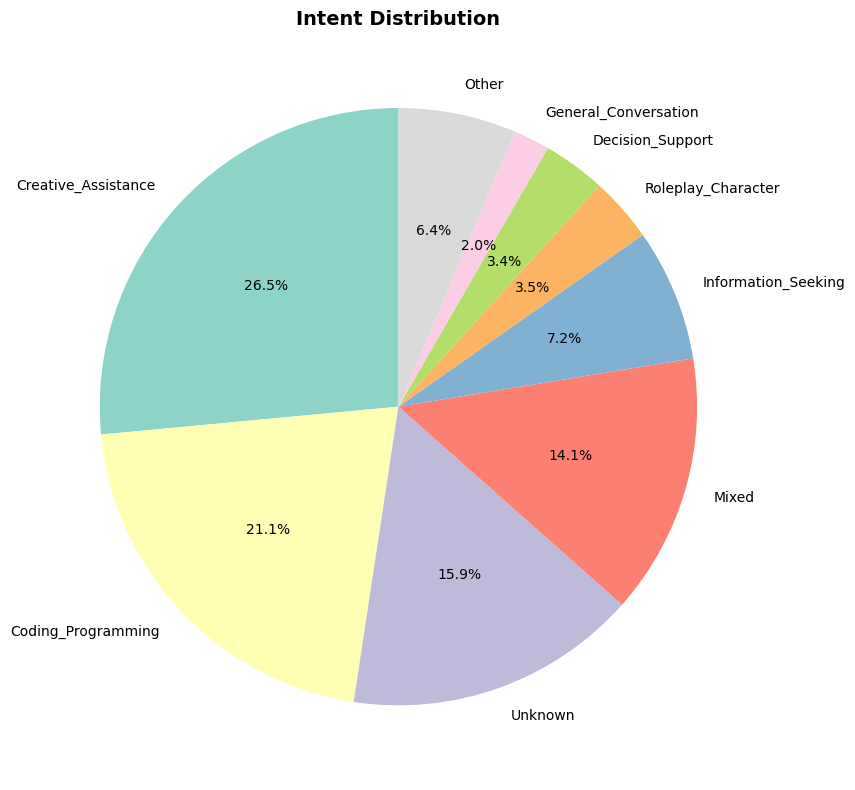

In [63]:
## Intent counts visualization
top_intents = intent_counts.head(8)
other_count = intent_counts.iloc[8:].sum() if len(intent_counts) > 8 else 0

if other_count > 0:
    plot_data = top_intents.tolist() + [other_count]
    plot_labels = top_intents.index.tolist() + ['Other']
else:
    plot_data = top_intents.values
    plot_labels = [label.replace('_', ' ') for label in top_intents.index]

# Plot
plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(range(len(plot_data)))

plt.pie(
    plot_data,
    labels=plot_labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)
plt.title('Intent Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [65]:
## Conversation lenght based on intent

for intent in df_messages['intent'].value_counts().index:
    rows = df_messages[df_messages['intent'] == intent]
    count = len(rows)
    avg_turns = rows['total_turns'].mean()
    med_turns = rows['total_turns'].median()
    max_turns = rows['total_turns'].max()

    print(f"{intent:<25}: {count:,} convs | avg: {avg_turns:.1f} turns | median: {med_turns:.1f} | max: {max_turns}")


Creative_Assistance      : 75,270 convs | avg: 3.2 turns | median: 2.0 | max: 96
Coding_Programming       : 60,005 convs | avg: 3.6 turns | median: 2.0 | max: 90
Unknown                  : 45,067 convs | avg: 5.4 turns | median: 4.0 | max: 128
Mixed                    : 40,136 convs | avg: 4.4 turns | median: 2.0 | max: 104
Information_Seeking      : 20,368 convs | avg: 5.8 turns | median: 4.0 | max: 90
Roleplay_Character       : 9,987 convs | avg: 3.9 turns | median: 2.0 | max: 96
Decision_Support         : 9,642 convs | avg: 5.4 turns | median: 2.0 | max: 120
General_Conversation     : 5,586 convs | avg: 8.3 turns | median: 6.0 | max: 80
Text_Editing_Formatting  : 4,381 convs | avg: 6.2 turns | median: 2.0 | max: 156
Math_Calculations        : 4,354 convs | avg: 5.0 turns | median: 2.0 | max: 142
Problem_Solving          : 3,718 convs | avg: 5.3 turns | median: 2.0 | max: 110
Learning_Skill_Development: 3,632 convs | avg: 5.0 turns | median: 2.0 | max: 68
Translation_Language     : 2

In [69]:
## Topic Modeling

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import re
import string
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


## Download required NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
except:
    print("NLTK download failed, using basic preprocessing")

## Get all intent categories and their counts
all_intents = df_messages['intent'].value_counts()

categories_for_modeling = []
for intent, count in all_intents.items():
    if intent not in ['Unknown']:  
        if count >= 100:  
            categories_for_modeling.append((intent, count))
        else:
            status = "Too small"

print(f"\nCategories selected for topic modeling: {len(categories_for_modeling)}")
print(f"Total conversations to analyze: {sum(count for _, count in categories_for_modeling):,}")

## Text preprocessing 
class TextPreprocessor:
    def __init__(self):
        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = {
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
                'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
                'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
                'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after',
                'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                'further', 'then', 'once'
            }
        
        self.stop_words.update({
            'please', 'could', 'would', 'can', 'need', 'want', 'like', 'help', 'make', 'get',
            'also', 'one', 'two', 'use', 'way', 'time', 'good', 'new', 'first', 'last',
            'long', 'great', 'little', 'own', 'other', 'old', 'right', 'big', 'high', 'different',
            'small', 'large', 'next', 'early', 'young', 'important', 'few', 'public', 'bad',
            'same', 'able'
        })
    
    def clean_text(self, text):
        """Clean and preprocess text for topic modeling"""
        if not text or pd.isna(text):
            return ""
        
        text = text.lower()
        
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        text = re.sub(r'\S+@\S+', '', text)
        
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        text = re.sub(r'\s+', ' ', text).strip()
        
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        
        tokens = [token for token in tokens 
                 if len(token) > 2 and token not in self.stop_words]
        
        return ' '.join(tokens)

preprocessor = TextPreprocessor()

## Define topic modeling parameters for different category sizes
def get_topic_params(num_docs):
    """Get appropriate number of topics based on dataset size"""
    if num_docs >= 50000:
        return {'n_topics': 15, 'description': 'Large dataset - 15 topics'}
    elif num_docs >= 20000:
        return {'n_topics': 12, 'description': 'Large dataset - 12 topics'}
    elif num_docs >= 10000:
        return {'n_topics': 10, 'description': 'Medium dataset - 10 topics'}
    elif num_docs >= 5000:
        return {'n_topics': 8, 'description': 'Medium dataset - 8 topics'}
    elif num_docs >= 1000:
        return {'n_topics': 6, 'description': 'Small dataset - 6 topics'}
    else:
        return {'n_topics': 4, 'description': 'Very small dataset - 4 topics'}


Categories selected for topic modeling: 12
Total conversations to analyze: 239,101


In [70]:
## Execute topic modeling

import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

topic_modeling_results = {}
processing_stats = []

def extract_top_words(model, feature_names, n_top_words=8):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
    return topics

def create_topic_name(top_words):
    return "_".join(top_words[:3]).title()

for intent, count in categories_for_modeling:
    print(f"\n{intent} ({count:,} messages)")
    print("-" * 40)
    
    start = time.time()
    intent_messages = df_messages[df_messages['intent'] == intent]['first_user_message']
    print(f"Messages to process: {len(intent_messages):,}")
    
    cleaned_texts = [preprocessor.clean_text(text) for text in intent_messages]
    cleaned_texts = [text for text in cleaned_texts if len(text.split()) >= 3]
    
    if len(cleaned_texts) < 50:
        print(f"Skipped — not enough clean messages ({len(cleaned_texts)})")
        continue
    
    print(f"Clean texts after filtering: {len(cleaned_texts):,}")
    
    params = get_topic_params(len(cleaned_texts))
    n_topics = params['n_topics']
    print(f"Fitting LDA model with {n_topics} topics...")

    try:
        vectorizer = CountVectorizer(
            max_features=1000,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'
        )
        doc_term_matrix = vectorizer.fit_transform(cleaned_texts)
        vocab = vectorizer.get_feature_names_out()
        print(f"Vocabulary size: {len(vocab)}")

        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            learning_method='online',
            learning_offset=50.0
        )
        lda.fit(doc_term_matrix)

        topics = extract_top_words(lda, vocab)
        topic_names = [create_topic_name(words) for words in topics]
        perplexity = lda.perplexity(doc_term_matrix)

        topic_modeling_results[intent] = {
            'n_topics': n_topics,
            'topics': topics,
            'topic_names': topic_names,
            'perplexity': perplexity,
            'n_documents': len(cleaned_texts),
            'vocabulary_size': len(vocab),
            'model': lda,
            'vectorizer': vectorizer
        }

        print("Topics:")
        for i, (name, words) in enumerate(zip(topic_names, topics)):
            print(f"  {i + 1}. {name:<20}  {', '.join(words[:5])}")

        elapsed = time.time() - start
        processing_stats.append({
            'intent': intent,
            'documents': len(cleaned_texts),
            'topics': n_topics,
            'time_seconds': elapsed,
            'perplexity': perplexity
        })

        print(f"Finished in {elapsed:.1f} seconds | Perplexity: {perplexity:.1f}")
    
    except Exception as e:
        print(f"Error processing {intent}: {str(e)}")
        continue

## Summary stats
print("\nSummary of topic modeling results")
print("-" * 60)
print(f"Categories processed: {len(topic_modeling_results)}")
total_docs = sum(result['n_documents'] for result in topic_modeling_results.values())
total_topics = sum(result['n_topics'] for result in topic_modeling_results.values())
avg_time = np.mean([s['time_seconds'] for s in processing_stats]) if processing_stats else 0

print(f"Total documents: {total_docs:,}")
print(f"Total topics: {total_topics}")
print(f"Average time per category: {avg_time:.1f} seconds")

## Breakdown by category
print("\nDetails by category")
print("-" * 70)
print(f"{'Intent':<30} {'Docs':<10} {'Topics':<8} {'Perplexity':<12} {'Status'}")

for intent, result in topic_modeling_results.items():
    docs = result['n_documents']
    topics = result['n_topics']
    perplexity = result['perplexity']
    
    if perplexity < 500:
        status = "Excellent"
    elif perplexity < 1000:
        status = "Good"
    elif perplexity < 2000:
        status = "Fair"
    else:
        status = "Poor"

    print(f"{intent:<30} {docs:<10,} {topics:<8} {perplexity:<12.1f} {status}")


Running topic modeling for each selected intent category
------------------------------------------------------------

Creative_Assistance (75,270 messages)
----------------------------------------
Messages to process: 75,270
Clean texts after filtering: 74,843
Fitting LDA model with 15 topics...
Vocabulary size: 1000
Topics:
  1. Capturing_Lake_Blue   capturing, lake, blue, cute, beautiful
  2. Create_World_People   create, world, people, human, work
  3. Coffee_Decor_Tables   coffee, decor, tables, coffee shop, beans
  4. Cup_Girl_Hair         cup, girl, hair, black, light
  5. Dog_Reminiscent_Natural  dog, reminiscent, natural, focused, compositions
  6. Mode_Message_Developer  mode, message, developer, developer mode, chatgpt
  7. Portraits_Words_Article  portraits, words, article, design, clear
  8. Women_Collar_Beautiful Women  women, collar, beautiful women, william, sipping
  9. Short_Say_Response    short, say, response, send, message asked
  10. Jane_Year_Jane Year   jane, ye

In [75]:
## Analysis of the results
print("COMPLETE TOPIC LIST BY INTENT CATEGORY")
print("=" * 70)
total_topics = 0

for intent, results in topic_modeling_results.items():
    print(f"{intent.upper().replace('_', ' ')}")
    print(f"  {results['n_documents']:,} documents | {results['n_topics']} topics | Perplexity: {results['perplexity']:.1f}")
    print("   " + "="*60)
    
    for i, (topic_name, topic_words) in enumerate(zip(results['topic_names'], results['topics']), 1):
        top_words = ', '.join(topic_words[:5])
        print(f"   {i:2d}. {topic_name:<30}: {top_words}")
    
    print()
    total_topics += results['n_topics']


COMPLETE TOPIC LIST BY INTENT CATEGORY
CREATIVE ASSISTANCE
  74,843 documents | 15 topics | Perplexity: 380.0
    1. Capturing_Lake_Blue           : capturing, lake, blue, cute, beautiful
    2. Create_World_People           : create, world, people, human, work
    3. Coffee_Decor_Tables           : coffee, decor, tables, coffee shop, beans
    4. Cup_Girl_Hair                 : cup, girl, hair, black, light
    5. Dog_Reminiscent_Natural       : dog, reminiscent, natural, focused, compositions
    6. Mode_Message_Developer        : mode, message, developer, developer mode, chatgpt
    7. Portraits_Words_Article       : portraits, words, article, design, clear
    8. Women_Collar_Beautiful Women  : women, collar, beautiful women, william, sipping
    9. Short_Say_Response            : short, say, response, send, message asked
   10. Jane_Year_Jane Year           : jane, year, jane year, episode, aaron
   11. Leonardo_Streaming_Cozy       : leonardo, streaming, cozy, iconic, shallow
   

In [77]:
## Business relevance analysis
print(f"BUSINESS RELEVANCE ANALYSIS")
print("=" * 50)

business_keywords = {
    'high_commercial': ['business', 'company', 'marketing', 'brand', 'product', 'service', 'strategy'],
    'technical': ['code', 'programming', 'web', 'app', 'api', 'development', 'software'],
    'content': ['write', 'create', 'content', 'article', 'blog', 'design', 'image'],
    'data': ['data', 'analysis', 'research', 'information', 'report', 'study'],
    'education': ['learn', 'teach', 'education', 'study', 'course', 'training'],
    'creative': ['story', 'character', 'creative', 'art', 'design', 'visual']
}

## Analyze each category for business themes
print("Business themes by intent category:")
print()

for intent, results in topic_modeling_results.items():
    print(f"{intent.replace('_', ' ')}")
    
    business_counts = {theme: 0 for theme in business_keywords.keys()}
    
    for topic_words in results['topics']:
        topic_text = ' '.join(topic_words[:5]).lower()
        
        for theme, keywords in business_keywords.items():
            for keyword in keywords:
                if keyword in topic_text:
                    business_counts[theme] += 1
                    break  # Count each topic only once per theme
    
    top_themes = sorted(business_counts.items(), key=lambda x: x[1], reverse=True)
    relevant_themes = [(theme, count) for theme, count in top_themes if count > 0]
    
    if relevant_themes:
        for theme, count in relevant_themes:
            percentage = (count / results['n_topics']) * 100
            print(f"   • {theme.replace('_', ' ').title()}: {count}/{results['n_topics']} topics ({percentage:.0f}%)")
    else:
        print("No clear business themes identified")
    print()

## Actionable topics
actionable_topics = [
    {
        'category': 'Creative_Assistance',
        'topic': 'Create_World_People',
        'keywords': 'create, world, people, human, work',
        'business_opportunity': 'Character creation tools, world-building assistants'
    },
    {
        'category': 'Creative_Assistance', 
        'topic': 'Portraits_Words_Article',
        'keywords': 'portraits, words, article, design, clear',
        'business_opportunity': 'Content creation tools, article writing assistants'
    },
    {
        'category': 'Coding_Programming',
        'topic': 'Let_Function_Canvas',
        'keywords': 'let, function, canvas, math, ctx',
        'business_opportunity': 'Web development tools, JavaScript assistants'
    },
    {
        'category': 'Coding_Programming',
        'topic': 'Const_Div_Class',
        'keywords': 'const, div, class, style, color',
        'business_opportunity': 'CSS/HTML code generators, web design tools'
    },
    {
        'category': 'Information_Seeking',
        'topic': 'Data_Tell_Research',
        'keywords': 'data, tell, research, power, company',
        'business_opportunity': 'Business intelligence tools, research assistants'
    },
    {
        'category': 'Decision_Support',
        'topic': 'Best_Answer_Suggest',
        'keywords': 'best, answer, suggest, question, choose',
        'business_opportunity': 'Recommendation engines, decision support tools'
    },
    {
        'category': 'Text_Editing_Formatting',
        'topic': 'Rewrite_Improve_Format',
        'keywords': 'rewrite, improve, format, following, style',
        'business_opportunity': 'Writing enhancement tools, editing assistants'
    },
    {
        'category': 'Text_Editing_Formatting',
        'topic': 'Grammar_Academic_Sentence',
        'keywords': 'grammar, academic, sentence, polish, paragraph',
        'business_opportunity': 'Academic writing tools, grammar checkers'
    }
]

for i, topic in enumerate(actionable_topics, 1):
    print(f"{i}. {topic['category'].replace('_', ' ')} → {topic['topic']}")
    print(f"   Keywords: {topic['keywords']}")
    print(f"   Opportunity: {topic['business_opportunity']}")
    print()


BUSINESS RELEVANCE ANALYSIS
Business themes by intent category:

Creative Assistance
   • Content: 2/15 topics (13%)
   • Creative: 2/15 topics (13%)

Coding Programming
   • Data: 3/15 topics (20%)
   • Technical: 1/15 topics (7%)
   • Content: 1/15 topics (7%)
   • Creative: 1/15 topics (7%)

Mixed
   • Content: 2/12 topics (17%)
   • Data: 2/12 topics (17%)
   • High Commercial: 1/12 topics (8%)
   • Creative: 1/12 topics (8%)

Information Seeking
   • High Commercial: 2/10 topics (20%)
   • Data: 2/10 topics (20%)
   • Creative: 1/10 topics (10%)

Roleplay Character
   • Creative: 2/8 topics (25%)

Decision Support
   • High Commercial: 1/8 topics (12%)
   • Data: 1/8 topics (12%)

Text Editing Formatting
   • Content: 2/6 topics (33%)
   • Creative: 1/6 topics (17%)

Math Calculations
   • Content: 1/6 topics (17%)
   • Data: 1/6 topics (17%)

Problem Solving
   • Data: 1/6 topics (17%)
   • Creative: 1/6 topics (17%)

Learning Skill Development
   • Education: 5/6 topics (83%)
  

In [81]:
## Analyzing Information Seeking Behavior

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

print("INFORMATION SEEKING BEHAVIOR ANALYSIS")
print("=" * 70)

info_seeking_conversations = df_messages[df_messages['intent'] == 'Information_Seeking']

print(f"DATASET OVERVIEW")
print("=" * 40)
print(f"Total Information Seeking conversations: {len(info_seeking_conversations):,}")
print(f"Percentage of total dataset: {(len(info_seeking_conversations)/len(df_messages))*100:.1f}%")
print(f"Average conversation length: {info_seeking_conversations['total_turns'].mean():.1f} turns")
print(f"Median conversation length: {info_seeking_conversations['total_turns'].median():.1f} turns")

## Analyze conversation patterns
print(f"CONVERSATION INTERACTION PATTERNS")
print("=" * 50)

# Length distribution analysis
length_distribution = info_seeking_conversations['total_turns'].value_counts().sort_index()
print("Conversation length patterns:")
for turns in [1, 2, 3, 4, 5]:
    if turns in length_distribution.index:
        count = length_distribution[turns]
        percentage = (count / len(info_seeking_conversations)) * 100
        print(f"  {turns} turn(s): {count:,} conversations ({percentage:.1f}%)")

## Analyze question types and patterns
print(f"QUESTION PATTERN ANALYSIS")
print("=" * 40)

## Extract first user messages to analyze question patterns
sample_messages = info_seeking_conversations['first_user_message'].dropna().sample(min(1000, len(info_seeking_conversations)), random_state=42)

## Analyze question starters
question_starters = {
    'what': 0, 'how': 0, 'why': 0, 'when': 0, 'where': 0, 'who': 0,
    'can': 0, 'could': 0, 'would': 0, 'should': 0, 'is': 0, 'are': 0,
    'do': 0, 'does': 0, 'did': 0, 'explain': 0, 'tell': 0, 'define': 0
}

question_complexity = {
    'simple_fact': 0,      # Single fact questions
    'comparison': 0,       # Comparing things
    'explanation': 0,      # How/why explanations
    'definition': 0,       # What is X
    'process': 0,          # How to do something
    'analysis': 0          # Complex analytical questions
}

## Keywords that indicate complexity
comparison_words = ['vs', 'versus', 'compare', 'difference', 'better', 'worse']
explanation_words = ['explain', 'why', 'how does', 'what causes', 'reason']
definition_words = ['what is', 'define', 'meaning', 'definition']
process_words = ['how to', 'steps', 'process', 'procedure']
analysis_words = ['analyze', 'implications', 'impact', 'consequences', 'trends']

for message in sample_messages:
    if pd.notna(message):
        message_lower = message.lower()
        
        for starter in question_starters.keys():
            if message_lower.startswith(starter):
                question_starters[starter] += 1
                break
        
        if any(word in message_lower for word in comparison_words):
            question_complexity['comparison'] += 1
        elif any(word in message_lower for word in analysis_words):
            question_complexity['analysis'] += 1
        elif any(word in message_lower for word in explanation_words):
            question_complexity['explanation'] += 1
        elif any(word in message_lower for word in definition_words):
            question_complexity['definition'] += 1
        elif any(word in message_lower for word in process_words):
            question_complexity['process'] += 1
        else:
            question_complexity['simple_fact'] += 1

print("Most common question starters:")
sorted_starters = sorted(question_starters.items(), key=lambda x: x[1], reverse=True)
for starter, count in sorted_starters[:8]:
    if count > 0:
        percentage = (count / len(sample_messages)) * 100
        print(f"  '{starter}': {count} ({percentage:.1f}%)")

print(f"\nQuestion complexity distribution:")
total_complexity = sum(question_complexity.values())
for complexity_type, count in sorted(question_complexity.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_complexity) * 100
    print(f"  {complexity_type.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")


INFORMATION SEEKING BEHAVIOR ANALYSIS
DATASET OVERVIEW
Total Information Seeking conversations: 20,368
Percentage of total dataset: 7.2%
Average conversation length: 5.8 turns
Median conversation length: 4.0 turns
CONVERSATION INTERACTION PATTERNS
Conversation length patterns:
  2 turn(s): 9,429 conversations (46.3%)
  4 turn(s): 3,951 conversations (19.4%)
QUESTION PATTERN ANALYSIS
Most common question starters:
  'what': 503 (50.3%)
  'how': 147 (14.7%)
  'why': 62 (6.2%)
  'explain': 61 (6.1%)
  'who': 43 (4.3%)
  'when': 17 (1.7%)
  'where': 11 (1.1%)
  'tell': 9 (0.9%)

Question complexity distribution:
  Simple Fact: 500 (50.0%)
  Definition: 237 (23.7%)
  Explanation: 201 (20.1%)
  Comparison: 41 (4.1%)
  Analysis: 13 (1.3%)
  Process: 8 (0.8%)


PURCHASE INTENT BEHAVIOR ANALYSIS
PURCHASE INTENT DATASET
Total purchase intent conversations: 1295
CONVERSATION ENGAGEMENT PATTERNS
Average conversation length: 4.4 turns
Median conversation length: 2.0 turns
Longest purchase conversation: 48 turns
Average initial message length: 2132 characters
Median initial message length: 935 characters
PURCHASE INTENT TYPE
  Price Cost Budget: 597 (41.7%)
  Direct Buying Intent: 498 (34.8%)
  Recommendation Seeking: 299 (20.9%)
  Product Comparison: 37 (2.6%)
PRICE POINT AND VALUE ANALYSIS
Price mentions found: 792
Average price mentioned: $956,144
Median price mentioned: $300
Price range: $0 - $50,000,000

TOP PRODUCT CATEGORIES
Software & Apps           |  597 conversations | Avg Turns:  4.3 | Avg Length: 3662.2
Services & Insurance      |  404 conversations | Avg Turns:  4.3 | Avg Length: 3749.0
Automotive                |  401 conversations | Avg Turns:  4.2 | Avg Length: 4071.0
Home & Construction       |  319 conversations | Avg Turns:  3.9

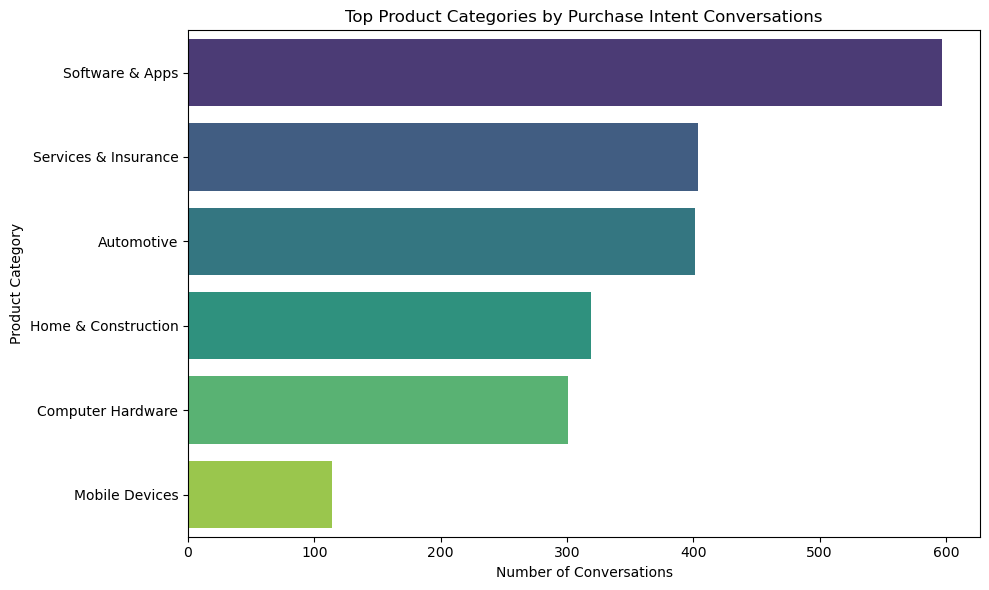

In [90]:
## Purchase Intent Analysis

import pandas as pd
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("PURCHASE INTENT BEHAVIOR ANALYSIS")
print("=" * 60)

decision_conversations = df_messages[df_messages['intent'] == 'Decision_Support']
mixed_conversations = df_messages[df_messages['intent'] == 'Mixed']

purchase_intent_patterns = {
    'direct_buying_intent': [
        r'should i buy', r'worth buying', r'thinking of buying', r'want to buy',
        r'planning to buy', r'considering buying', r'buy.*or.*', r'purchase.*or.*'
    ],
    'product_comparison': [
        r'.*vs.*\b(iphone|samsung|apple|tesla|bmw|toyota|honda|nike|adidas)\b',
        r'.*vs.*\b(laptop|phone|car|camera|headphones|macbook|ipad)\b',
        r'compare.*\b(laptop|phone|car|camera|headphones|software|app|service)\b',
    ],
    'recommendation_seeking': [
        r'recommend.*\b(phone|laptop|car|camera|headphones|software|app|book|course|service)\b',
        r'best.*\b(phone|laptop|car|camera|headphones|software|app|book|course)\b',
        r'what.*\b(phone|laptop|car|camera|headphones|software|app)\b.*should.*get',
    ],
    'price_cost_budget': [
        r'how much.*cost', r'price.*of.*', r'budget.*for.*', r'affordable.*', r'cheap.*'
    ]
}

## Extract purchase intent conversations
def extract_purchase_conversations(conversations, category_name):
    purchase_conversations = []
    
    for idx, row in conversations.iterrows():
        message = row['first_user_message']
        if pd.notna(message):
            message_lower = message.lower()
            matched_patterns = []
            
            for pattern_type, patterns in purchase_intent_patterns.items():
                for pattern in patterns:
                    if re.search(pattern, message_lower):
                        matched_patterns.append(pattern_type)
                        break
            
            if matched_patterns:
                purchase_conversations.append({
                    'conversation_id': row['conversation_id'],
                    'category': category_name,
                    'message': message,
                    'matched_patterns': matched_patterns,
                    'total_turns': row['total_turns'],
                    'user_turns': row['user_turns'], 
                    'assistant_turns': row['assistant_turns'],
                    'model': row['model'],
                    'timestamp': row['timestamp'],
                    'message_length': len(message)
                })
    
    return purchase_conversations

decision_purchases = extract_purchase_conversations(decision_conversations, 'Decision_Support')
mixed_purchases = extract_purchase_conversations(mixed_conversations, 'Mixed')

all_purchases = decision_purchases + mixed_purchases
purchase_df = pd.DataFrame(all_purchases)

print(f"PURCHASE INTENT DATASET")
print(f"Total purchase intent conversations: {len(purchase_df)}")

if len(purchase_df) > 0:
    print(f"CONVERSATION ENGAGEMENT PATTERNS")
    print("=" * 45)
    
    engagement_stats = {
        'avg_total_turns': purchase_df['total_turns'].mean(),
        'median_total_turns': purchase_df['total_turns'].median(),
        'max_turns': purchase_df['total_turns'].max(),
        'avg_message_length': purchase_df['message_length'].mean(),
        'median_message_length': purchase_df['message_length'].median()
    }
    
    print(f"Average conversation length: {engagement_stats['avg_total_turns']:.1f} turns")
    print(f"Median conversation length: {engagement_stats['median_total_turns']:.1f} turns")
    print(f"Longest purchase conversation: {engagement_stats['max_turns']} turns")
    print(f"Average initial message length: {engagement_stats['avg_message_length']:.0f} characters")
    print(f"Median initial message length: {engagement_stats['median_message_length']:.0f} characters")
    

    print(f"PURCHASE INTENT TYPE")
    print("=" * 40)
    
    all_patterns = []
    for patterns in purchase_df['matched_patterns']:
        all_patterns.extend(patterns)
    
    pattern_counts = Counter(all_patterns)
    total_patterns = sum(pattern_counts.values())
    
    for pattern, count in pattern_counts.most_common():
        percentage = (count / total_patterns) * 100
        print(f"  {pattern.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
    
    print(f"PRICE POINT AND VALUE ANALYSIS")
    print("=" * 40)
    
    price_patterns = [
        r'\$([0-9,]+)', r'([0-9,]+)\s*dollars?', r'([0-9,]+)\s*USD',
        r'([0-9,]+)\s*AED', r'([0-9,]+)\s*euros?', r'([0-9,]+)\s*pounds?',
        r'under\s+([0-9,]+)', r'below\s+([0-9,]+)', r'less than\s+([0-9,]+)'
    ]
    
    price_mentions = []
    high_value_conversations = []
    
    for _, row in purchase_df.iterrows():
        message = row['message']
        for pattern in price_patterns:
            matches = re.findall(pattern, message.lower())
            for match in matches:
                try:
                    price_str = match.replace(',', '')
                    price = float(price_str)
                    price_mentions.append(price)
                    
                    if price > 500:  
                        high_value_conversations.append({
                            'message': message,
                            'price': price,
                            'turns': row['total_turns']
                        })
                except:
                    continue
    
    if price_mentions:
        print(f"Price mentions found: {len(price_mentions)}")
        print(f"Average price mentioned: ${np.mean(price_mentions):,.0f}")
        print(f"Median price mentioned: ${np.median(price_mentions):,.0f}")
        print(f"Price range: ${min(price_mentions):,.0f} - ${max(price_mentions):,.0f}")
    
    ## Product categorization
    product_categories = {
        'Computer Hardware': [
            'laptop', 'pc', 'computer', 'macbook', 'cpu', 'gpu', 'ram', 'processor',
            'rtx', 'ryzen', 'intel', 'graphics card', 'motherboard', 'ssd'
        ],
        'Mobile Devices': [
            'phone', 'iphone', 'samsung', 'android', 'smartphone', 'mobile',
            'ipad', 'tablet', 'pixel', 'oneplus'
        ],
        'Automotive': [
            'car', 'motorcycle', 'bike', 'tesla', 'bmw', 'toyota', 'honda',
            'kawasaki', 'suzuki', 'benelli', 'vehicle'
        ],
        'Home & Construction': [
            'tiles', 'bathroom', 'house', 'home', 'renovation', 'container',
            'server room', 'construction', 'building'
        ],
        'Services & Insurance': [
            'insurance', 'captcha', 'provider', 'service', 'strategy',
            'business', 'professional'
        ],
        'Software & Apps': [
            'app', 'software', 'program', 'platform', 'tool', 'system'
        ]
    }
    
    category_matches = defaultdict(list)

    for _, row in purchase_df.iterrows():
        message = row['message'].lower()
        for category, keywords in product_categories.items():
            for keyword in keywords:
                if keyword in message:
                    category_matches[category].append({
                        'message': row['message'],
                        'turns': row['total_turns'],
                        'length': row['message_length']
                    })
                    break

## Summarize category matches
category_summary = []

for category, matches in category_matches.items():
    n = len(matches)
    avg_turns = np.mean([m['turns'] for m in matches])
    avg_length = np.mean([m['length'] for m in matches])
    
    category_summary.append({
        'category': category,
        'conversations': n,
        'avg_turns': round(avg_turns, 1),
        'avg_length': round(avg_length, 1)
    })

category_df = pd.DataFrame(category_summary).sort_values(by='conversations', ascending=False)

print("\nTOP PRODUCT CATEGORIES")
print("=" * 50)
for _, row in category_df.iterrows():
    print(f"{row['category']:<25} | {row['conversations']:>4} conversations | "
          f"Avg Turns: {row['avg_turns']:>4} | Avg Length: {row['avg_length']:>5}")

plt.figure(figsize=(10, 6))
sns.barplot(y='category', x='conversations', data=category_df, palette='viridis')
plt.title("Top Product Categories by Purchase Intent Conversations")
plt.xlabel("Number of Conversations")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()
    
    

In [ ]:
## Using OPEN AI API to evaluate the purchase intent of the conversations
## Note: I used gpt-3.5-turbo since it is cheaper, 
## I have detected some problems in task execution which I believe would not be an issue with GPT 4o.

import openai
import pandas as pd
import json
import time
from datetime import datetime
from openai import OpenAI

client = OpenAI(api_key=" ") 

def analyze_purchase_conversation(message, client):
    prompt = f"""Analyze this conversation for purchase intent and market insights.

Conversation: "{message}"

Please provide a JSON response with:
1. purchase_intent_score: 1-10 (1=no intent, 10=ready to buy)
2. purchase_category: [electronics, software, automotive, apparel, home_garden, health_beauty, books_media, food_beverage, travel, financial_services, education, professional_services, sports_fitness, toys_games, other, none]
3. specific_product: [exact product mentioned or "none"]
4. price_range: [under_100, 100_500, 500_2000, over_2000, not_mentioned]
5. decision_stage: [research, compare, ready_to_buy, price_shopping]
6. key_decision_factors: [up to 3 main factors like "price", "features", "brand", "reviews", "quality"]"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a market research analyst. Respond only with valid JSON."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,
            max_tokens=300
        )
        result = json.loads(response.choices[0].message.content)
        return result, True
    except Exception as e:
        print(f"Error: {e}")
        return {'error': str(e), 'purchase_intent_score': 0, 'purchase_category': 'error'}, False

print("Analysis started")

results = []
total_conversations = len(purchase_df)

## Purchase_df contains decision conversations and mixed conversation as they had the most potential to include
## purchase intent conversation
for i, (idx, row) in enumerate(purchase_df.iterrows()):
    if i % 100 == 0:
        print(f"Processed: {i}/{total_conversations}")
    
    result, success = analyze_purchase_conversation(row['message'], client)
    
    result.update({
        'conversation_id': row['conversation_id'],
        'original_message': row['message'][:200] + "..." if len(row['message']) > 200 else row['message'],
        'original_category': row['original_category'],
        'total_turns': row['total_turns'],
        'message_length': len(row['message'])
    })
    
    results.append(result)
    time.sleep(0.2)

full_results_df = pd.DataFrame(results)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"full_purchase_analysis_{timestamp}.csv"
full_results_df.to_csv(filename, index=False)

print("Analysis ended")

In [ ]:
results

In [94]:
import pandas as pd
import numpy as np
from datetime import datetime

print("ANALYZING PURCHASE INTENT RESULTS")
print("=" * 50)

if 'full_results_df' in locals():
    
    clean_df = full_results_df.copy()
    
    for idx, row in clean_df.iterrows():
        for col in ['purchase_category', 'key_decision_factors']:
            if isinstance(row.get(col), list):
                clean_df.at[idx, col] = ', '.join(str(item) for item in row[col])
    
    for col in clean_df.columns:
        clean_df[col] = clean_df[col].astype(str)
    
    total_analyzed = len(clean_df)
    errors = len(clean_df[clean_df['purchase_category'] == 'error'])
    valid_results = clean_df[clean_df['purchase_category'] != 'error']
    
    print(f"Total conversations analyzed: {total_analyzed:,}")
    print(f"Successful analyses: {len(valid_results):,}")
    print(f"Errors: {errors}")
    print(f"Success rate: {(len(valid_results)/total_analyzed)*100:.1f}%")
    
    if len(valid_results) > 0:
        
        print(f"PURCHASE INTENT SCORES")
        print("-" * 30)
        
        intent_scores = valid_results['purchase_intent_score'].astype(int).value_counts().sort_index()
        
        low_intent = 0  #1-3
        medium_intent = 0  #4-6  
        high_intent = 0  #7-10
        
        for score in range(1, 11):
            count = intent_scores.get(score, 0)
            if 1 <= score <= 3:
                low_intent += count
            elif 4 <= score <= 6:
                medium_intent += count
            elif 7 <= score <= 10:
                high_intent += count
        
        total_valid = len(valid_results)
        print(f"Low Intent (1-3): {low_intent:,} ({(low_intent/total_valid)*100:.1f}%)")
        print(f"Medium Intent (4-6): {medium_intent:,} ({(medium_intent/total_valid)*100:.1f}%)")
        print(f"High Intent (7-10): {high_intent:,} ({(high_intent/total_valid)*100:.1f}%)")
        
        print(f"PURCHASE CATEGORIES")
        print("-" * 25)
        
        real_categories = valid_results[valid_results['purchase_category'] != 'none']
        
        if len(real_categories) > 0:
            categories = real_categories['purchase_category'].value_counts()
            print(f"Conversations with real categories: {len(real_categories):,}")
            print("Top categories:")
            for category, count in categories.head(10).items():
                percentage = (count / len(real_categories)) * 100
                print(f"  {category}: {count:,} ({percentage:.1f}%)")
        
        print(f"HIGH INTENT ANALYSIS (Score 7+)")
        print("-" * 35)
        
        high_intent_df = valid_results[valid_results['purchase_intent_score'].astype(int) >= 7]
        
        if len(high_intent_df) > 0:
            print(f"High intent conversations: {len(high_intent_df):,}")            
            high_categories = high_intent_df['purchase_category'].value_counts()
            print("High intent categories:")
            for category, count in high_categories.head(8).items():
                print(f"  {category}: {count:,}")
        
        print(f"BUSINESS INSIGHTS")
        print("-" * 22)
        
        total_original_conversations = 284168 
        original_purchase_detection_rate = 0.00456  
        true_high_intent_rate = len(high_intent_df) / len(valid_results)
        
        estimated_real_purchase_conversations = total_original_conversations * original_purchase_detection_rate * true_high_intent_rate
        
        print(f"Estimated real purchase conversations in full dataset: {estimated_real_purchase_conversations:.0f}")
        print(f"True purchase intent rate: {(estimated_real_purchase_conversations/total_original_conversations)*100:.3f}% of all conversations")
        print(f"Market validation: {(high_intent/total_valid)*100:.1f}% of detected purchase conversations are genuine")
        
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"purchase_analysis_complete_{timestamp}.csv"
        
        clean_df.to_csv(filename, index=False, encoding='utf-8')
        print(f"Results saved to: {filename}")
        
    except Exception as e:
        try:
            filename = f"purchase_analysis_complete_{timestamp}.txt"
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(clean_df.to_string())
        except:
            print(f"Could not save results: {e}")
    
    if len(valid_results) > 0:
        print(f"SUMMARY STATISTICS")
        print("-" * 22)
        print(f"• Total analyzed: {total_analyzed:,}")
        print(f"• High intent: {high_intent:,} ({(high_intent/total_valid)*100:.1f}%)")
        print(f"• Success rate: {(len(valid_results)/total_analyzed)*100:.1f}%")
        print(f"• Top category: {categories.index[0] if 'categories' in locals() and len(categories) > 0 else 'N/A'}")    
else:
    print("No full_results_df found")


ANALYZING PURCHASE INTENT RESULTS
Total conversations analyzed: 1,269
Successful analyses: 1,267
Errors: 2
Success rate: 99.8%
PURCHASE INTENT SCORES
------------------------------
Low Intent (1-3): 704 (55.6%)
Medium Intent (4-6): 231 (18.2%)
High Intent (7-10): 332 (26.2%)
PURCHASE CATEGORIES
-------------------------
Conversations with real categories: 1,210
Top categories:
  electronics: 203 (16.8%)
  financial_services: 148 (12.2%)
  professional_services: 124 (10.2%)
  books_media: 116 (9.6%)
  apparel: 90 (7.4%)
  software: 88 (7.3%)
  education: 75 (6.2%)
  health_beauty: 62 (5.1%)
  home_garden: 56 (4.6%)
  food_beverage: 56 (4.6%)
HIGH INTENT ANALYSIS (Score 7+)
-----------------------------------
High intent conversations: 332
High intent categories:
  electronics: 54
  apparel: 35
  books_media: 32
  health_beauty: 30
  financial_services: 30
  professional_services: 25
  food_beverage: 24
  home_garden: 24
BUSINESS INSIGHTS
----------------------
Estimated real purchase co

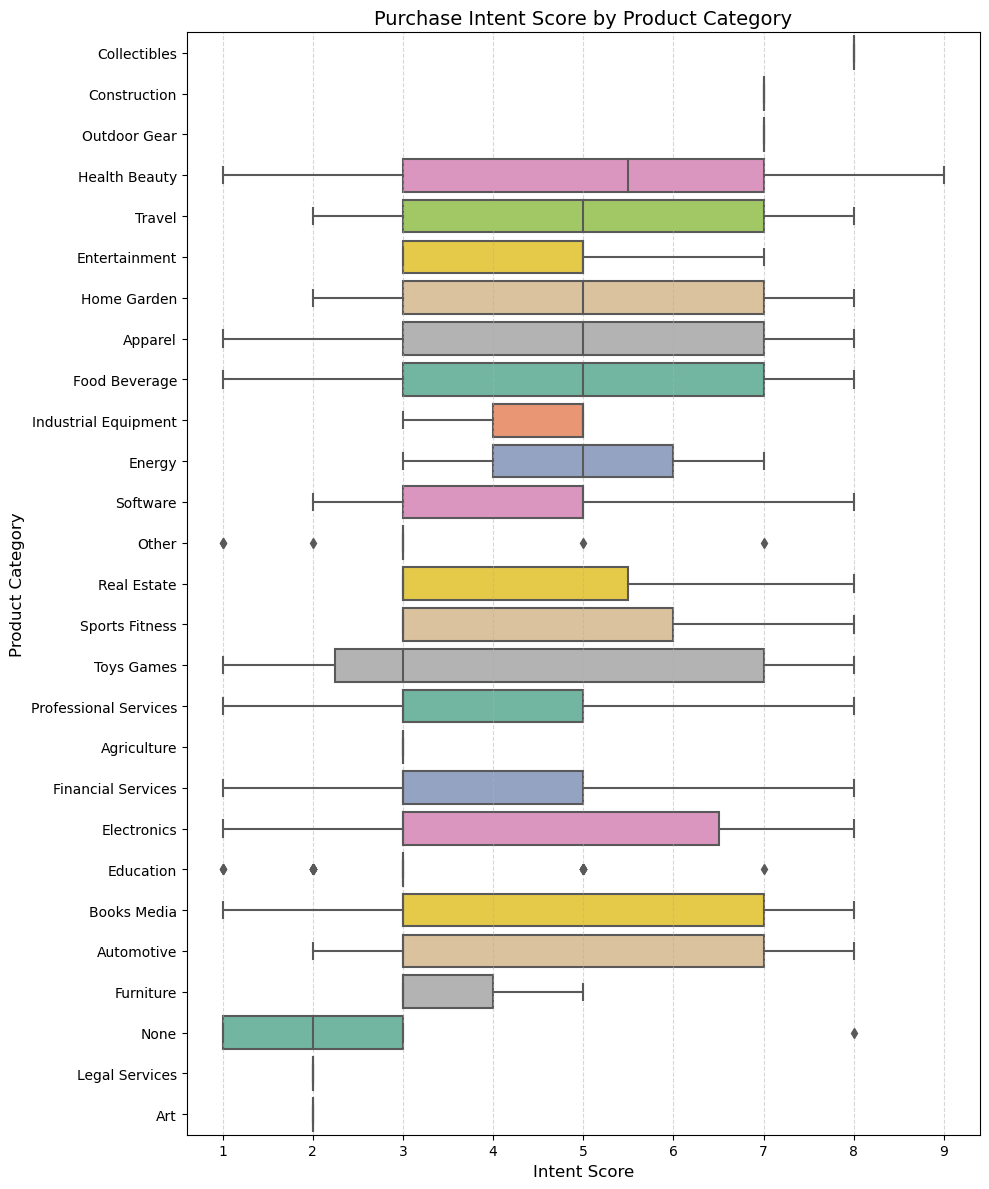

In [98]:
## Intent score distribution by category
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = valid_results.copy()
plot_df['purchase_category'] = (
    plot_df['purchase_category']
    .str.replace('_', ' ')
    .str.title()
    .apply(lambda x: x.split(',')[0].strip() if ',' in x else x.strip())
)

plot_df['purchase_intent_score'] = pd.to_numeric(plot_df['purchase_intent_score'], errors='coerce')
plot_df = plot_df.dropna(subset=['purchase_intent_score'])

category_order = (
    plot_df.groupby('purchase_category')['purchase_intent_score']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 12))
sns.boxplot(
    data=plot_df,
    x='purchase_intent_score',
    y='purchase_category',
    order=category_order,
    palette="Set2"
)

plt.title("Purchase Intent Score by Product Category", fontsize=14)
plt.xlabel("Intent Score", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



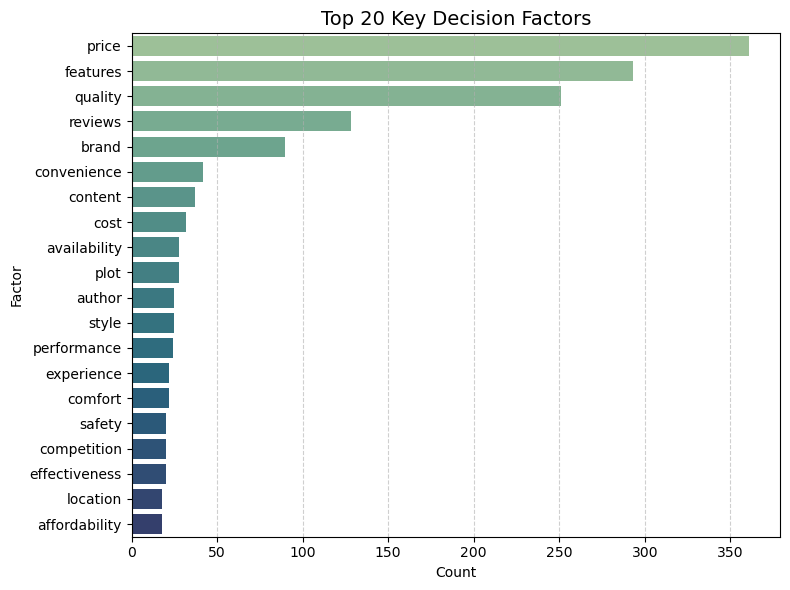

In [100]:
## Key Decision Factors Frequency

import matplotlib.pyplot as plt
import seaborn as sns

factors_df = valid_results.copy()
factors_df['key_decision_factors'] = factors_df['key_decision_factors'].astype(str)

factors_df['key_decision_factors'] = factors_df['key_decision_factors'].str.split(',')
factors_exploded = factors_df.explode('key_decision_factors')

factors_exploded['key_decision_factors'] = (
    factors_exploded['key_decision_factors']
    .str.strip()
    .str.lower()
)

top_factors = (
    factors_exploded['key_decision_factors']
    .value_counts()
    .head(20)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    y=top_factors.index,
    x=top_factors.values,
    palette="crest"
)

plt.title("Top 20 Key Decision Factors", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Factor")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



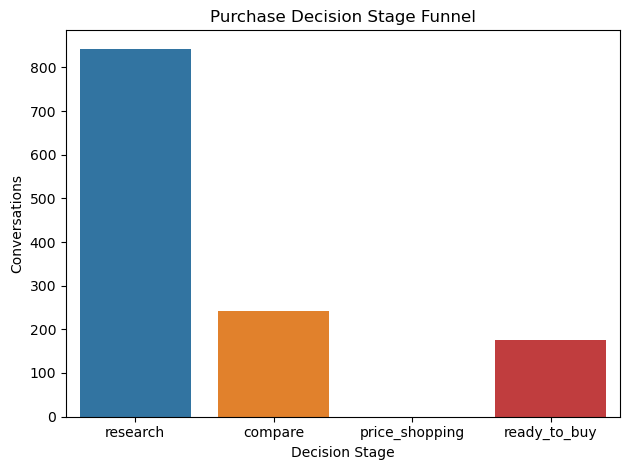

In [103]:
## Decision Stage distribution

funnel_order = ['research', 'compare', 'price_shopping', 'ready_to_buy']
stage_counts = valid_results['decision_stage'].value_counts().reindex(funnel_order)

sns.barplot(x=stage_counts.index, y=stage_counts.values)
plt.title("Purchase Decision Stage Funnel")
plt.xlabel("Decision Stage")
plt.ylabel("Conversations")
plt.tight_layout()
plt.show()
